In [1]:
import numpy as np
from pandas import DataFrame
import matplotlib
import matplotlib.pyplot as plt

# Setup

Files:

In [2]:
DATA_DIR = "../data/runs"
SO_DIR = DATA_DIR + "/so-all.log" #original snippets
SO_AFTER_DIR = DATA_DIR + "/so-all-after.log" #snippets after edits

#reduction in errors ONLY set
SO_IMPROVE_DIR = DATA_DIR + "/so-improved.log" #original snippets
SO_IMPROVE_AFTER_DIR = DATA_DIR + "/so-improved-after.log" #snippets after edits

#fixed ONLY set
SO_FIXED_DIR = DATA_DIR + "/so-fixed.log" #original snippets
SO_FIXED_AFTER_DIR = DATA_DIR + "/so-fixed-after.log" #snippets after edits


## Error Labels

In [3]:
# error dict
error_labels = {
    "Cannot find name 'clone'. Did you mean 'close'?" : "Cannot find name (suggestion).",
    "Cannot find name 'json'. Did you mean 'JSON'?" : "Cannot find name (suggestion).",
    "Cannot find name 'requires'. Did you mean 'require'?" : "Cannot find name (suggestion).",
    "Cannot find name 'One'. Did you mean 'one'?": "Cannot find name (suggestion).",
    "Cannot find name '$DOMAIN'. Did you mean 'DOMAIN'?": "Cannot find name (suggestion).",
    "Cannot find name 'processes'. Did you mean 'process'?": "Cannot find name (suggestion).",
    "Cannot use JSX unless the '--jsx' flag is provided." : "JSX",
    "Left side of comma operator is unused and has no side effects." : "Left side comma operator unused",
    "Type annotations can only be used in TypeScript files." : "Type annotations",
    "A 'return' statement can only be used within a function body.": "Return outside function",
    "Property 'setState' does not exist on type 'UnicornEditor'.": "Property doesn't exist on type",
    "Property 'writeHead' does not exist on type 'string'." : "Property doesn't exist on type",
    "Property 'sendBody' does not exist on type 'ServerResponse<IncomingMessage> & { req: IncomingMessage; }'.": "Property doesn't exist on type",
    "Property 'returns' does not exist on type '(arg0: any) => void'." : "Property doesn't exist on type", #first error message the values r specific
    "Property 'log' does not exist on type '(arg0: any) => void'." : "Property doesn't exist on type", #first error message the values r specific
    "Top-level 'await' expressions are only allowed when the 'module' option is set to 'es2022' 'esnext' 'system' 'node16' or 'nodenext' and the 'target' option is set to 'es2017' or higher.": "Top level await",
    "Cannot find name 'it'. Do you need to install type definitions for a test runner? Try `npm i --save-dev @types/jest` or `npm i --save-dev @types/mocha` and then add 'jest' or 'mocha' to the types field in your tsconfig.": "Cannot find name (test runner)",
    "Cannot find name 'describe'. Do you need to install type definitions for a test runner? Try `npm i --save-dev @types/jest` or `npm i --save-dev @types/mocha` and then add 'jest' or 'mocha' to the types field in your tsconfig.": "Cannot find name (test runner)",
    "Cannot find name '$'. Do you need to install type definitions for jQuery? Try `npm i --save-dev @types/jquery` and then add 'jquery' to the types field in your tsconfig." : "Cannot find name (jQuery)",
    "Parsing error: Unexpected token": "Parsing.unexpectedToken",
    "Parsing error: 'import' and 'export' may appear only with 'sourceType: module'": "Parsing.importExport",
    "Parsing error: Unexpected character": "Parsing.unexpectedCharacter",
    "Parsing error: Identifier has already been declared": "Parsing.alreadyDeclared",
    "Parsing error: Invalid regular expression" : "Parsing.invalidRegEx",
    "Parsing error: Assigning to rvalue": "Parsing.assignedToRvalue",
    "Parsing error: Unterminated regular expression": "Parsing.unterminatedRegEx",
    "Parsing error: Identifier directly after number": "Parsing.identifierAfterNumber",
    "Parsing error: Unterminated string constant": "Parsing.unterminatedStringConstant",
    "Parsing error: Expecting Unicode escape sequence \\uXXXX":  "Parsing.expectedUnicodeEscape",
    "Parsing error: Cannot use keyword 'await' outside an async function": "Parsing.awaitNotInAsync",
    "Parsing error: Reserved keyword" : "Parsing.reservedKeyword",
    "Parsing error: 'return' outside of function" : "Parsing.returnNotInFunction",
    "Parsing error: Unterminated template": "Parsing.unterminatedTemplate",
}

def getLabels(errors):
    errors = list(errors)
    for i, e in enumerate(errors):
        if e in error_labels:
            e = error_labels[e]
        else:
            if e.endswith("."):
                e = e[:-1]
        errors[i] = e
    return errors

## Classes

In [4]:
class Log:

    def __init__(self, filename, heading = "ERROR, CODE, CATEGORY, NUM OCCURANCES, NUM AFFECTED SNIPPETS, FIRST ID, PERCENT"):
        rows = []
        self.snippets = None
        self.noErrors = None
        self.totalErrors = None
        self.fixed = None
        self.empty = None
        self.loc = None

        if isinstance(filename, str):
            file = open(filename, encoding="utf8")
            lines = file.readlines()
        else:
            lines = filename

        headings = []
        csv_mode = False
        for line in lines:
            line = line.strip()
            if line.startswith(heading):
                csv_mode = True
                headings = line.split(",")
                headings = [h.strip() for h in headings]
                continue
            if(csv_mode):
                if not line:
                    csv_mode = False
                    continue
                parts = line.split(",")
                to = len(headings)-1
                columns = ["".join(parts[0:-to])]
                for p in parts[-to:]:
                    p = p.strip()
                    if p == "true":
                        p = True
                    elif p == "undefined":
                        p = False
                    elif p == "":
                        p = None
                    else:
                        p = float(p)
                    columns.append(p)
                # columns += [float(p.strip()) for p in parts[-to:]]
                rows.append(columns)
                continue
            if line.startswith("Snippets without errors:"):
                self.noErrors = int(line.split(":")[1].split("/")[0])
            if(line.startswith("Total errors:")):
                self.totalErrors = int(line.split(":")[1])
            if(line.startswith("Fixed:")):
                self.fixed = int(line.split(":")[1].split("/")[0])
            if(line.startswith("Code lines:")):
                self.loc = int(line.split(":")[1])
            if(line.startswith("Snippets no lines:")):
                self.empty = int(line.split(":")[1].split("/")[0])
            if line.startswith("TOTAL SNIPPETS:"):
                self.snippets = int(line.split(":")[1].strip())
        
        self.errors = DataFrame.from_records(rows, columns=headings)

    def getLines(filename, heading, end):
        file = open(filename, encoding="utf8")
        lines = file.readlines()
        record = True
        newLines = []
        for line in lines:
            if line.startswith("--------"):
                record = False
            if line.startswith(heading):
                record = True
            if end and line.startswith(end):
                reocrd = False
            if record:
                newLines.append(line)
        return newLines
    

## Functions

In [5]:
# figures

fig_height = 3.5

#i cant spell occurrences...
def top10Errors(df, column, label="Occurrences (10K)", title="Common Error Types", saveas='commonErrorTypes', getLabels=getLabels, xlim=8000000, format=lambda x, p: format(int(x/1000000), ','), color = "ncc", df2 = None):
    if color == "ncc": color = "darkorange"
    elif color == "ncq": color = "darkblue"
    elif color == "SO": color = "#f48024"
    
    top10_df = df.nlargest(10, [column]).iloc[::-1]
    top10_df2 = None
    if(isinstance(df2, DataFrame)): 
        index = "CODE"
        # get the same values
        keys = list(top10_df[index])
        if None in keys:
            index = "ERROR"
            keys = list(top10_df[index])
        top10_df2 = df2[df2[index].isin(keys)].iloc[::-1]
        top10_df2 = top10_df2.set_index(index)
        top10_df2 = top10_df2.reindex(keys)
        top10_df2 = top10_df2.reset_index()
        

    fig, (ax1, ax2) = plt.subplots(1, 2, sharex="col", width_ratios=[3, 2])
    fig.set_size_inches(4, fig_height)

    ax1.barh(getLabels(top10_df["ERROR"]), top10_df[column], color=color)
    if(isinstance(df2, DataFrame)): ax1.barh(getLabels(top10_df2["ERROR"]), top10_df2[column], color=(0,0,0,0.3))
    ax = ax2.barh(range(0, 10), top10_df[column], color=color)
    if(isinstance(df2, DataFrame)): ax2.barh(range(0, 10), top10_df2[column], color=(0,0,0,0.3))

    fig.subplots_adjust(wspace=0.15)

    ax1.set_xlim(0, 6000)
    ax2.set_xlim(10000, xlim)

    ax1.spines.right.set_visible(False)
    ax2.spines.left.set_visible(False)
    ax2.tick_params(labelleft=False, left=False)
    ax2.yaxis.tick_right()

    d = .5  # proportion of vertical to horizontal extent of the slanted line
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
                linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    ax1.plot([1, 1], [0, 1], transform=ax1.transAxes, **kwargs)
    ax2.plot([0, 0], [1, 0], transform=ax2.transAxes, **kwargs)

    ax1.set_xlabel(label, x=1)
    ax1.set_ylabel("Errors")
    # ax.set_xlim(0, xlim)
    

    ax1.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: x/10000))
    ax2.get_xaxis().set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: x/10000))

    # ax2.get_xaxis().set_major_formatter(
    #     matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x/100), ',')))
    # ax1.tick_params(axis='both', which='major', labelsize=8.5)
    #fig.set_title(title)

    labels = []
    for n in top10_df[column]:
        if(n>1000000):
            n = str(round(n/1000000, 1)) + "m"
        else:
            n = int(n)
        labels.append(n)
    ax2.bar_label(ax, label_type='edge', labels=labels, padding=1, size=8)
    ax1.bar_label(ax, label_type='edge', labels=labels, padding=1, size=8)
    plt.savefig("figures/" + saveas, bbox_inches = "tight")
    plt.show()

## Load

In [6]:
so_errors = Log(Log.getLines(SO_DIR, "ERROR ANALYSIS", None))
soa_errors = Log(Log.getLines(SO_AFTER_DIR, "ERROR ANALYSIS", None))
so_errors_af =  Log(Log.getLines(SO_AFTER_DIR, "ALL FIXES ANALYSIS", None)) #all fixes
soa_errors_af =  Log(Log.getLines(SO_AFTER_DIR, "ALL FIXES ANALYSIS", None)) #all fixes

soi_errors = Log(Log.getLines(SO_IMPROVE_DIR, "ERROR ANALYSIS", None))
soia_errors = Log(Log.getLines(SO_IMPROVE_AFTER_DIR, "ERROR ANALYSIS", None))
soi_errors_af =  Log(Log.getLines(SO_IMPROVE_DIR, "ALL FIXES ANALYSIS", None)) #all fixes
soia_errors_af =  Log(Log.getLines(SO_IMPROVE_DIR, "ALL FIXES ANALYSIS", None)) #all fixes

sof_errors = Log(Log.getLines(SO_FIXED_DIR, "ERROR ANALYSIS", None))
sofa_errors = Log(Log.getLines(SO_FIXED_AFTER_DIR, "ERROR ANALYSIS", None))
sof_errors_af =  Log(Log.getLines(SO_FIXED_DIR, "ALL FIXES ANALYSIS", None)) #all fixes
sofa_errors_af =  Log(Log.getLines(SO_FIXED_DIR, "ALL FIXES ANALYSIS", None)) #all fixes

# Errors Between Manual Edits

## All Edits (Ignore)

How many errors between pre and post edits?

In [7]:
def overview(e, c = None):
    print("Total Snippets:", str(e.snippets))
    print("Total Errors:", str(e.totalErrors))
    if c:
        print("Error Difference (+/-):", str(-(c.totalErrors - e.totalErrors)))
    print("Average:", str(
        e.totalErrors / e.snippets
    ))
    print("Total LOC:", str(e.loc))
    if c:
        locdif = -(e.loc - c.loc)
        print("LOC Difference (+/-):", str(-(c.loc - e.loc)))
    print("Snippets with no Errors:", str(e.noErrors), "/", str(e.snippets), "(", str(e.noErrors/e.snippets), ")")
    if c:
        print("Snippets with no Errors Difference (+/-): " + str(-(c.noErrors - e.noErrors)))
        print("Snippets increased by: " + str(
            (e.noErrors - c.noErrors)/ c.noErrors
        ))
    wE = e.snippets-e.noErrors
    print("Snippets with Errors: " + str(wE) + "/" + str(e.snippets) + "(" + str(1 - e.noErrors/e.snippets) + ")")
    if c:
         wEc = c.snippets-c.noErrors
         print("Snippets with Errors Difference (+/-): " + str(-(wEc - wE)))
    if(e.totalErrors):
        print("Average for Error Set: " + str(
            e.totalErrors / wE
        ))
    else:
        print("Average for Error Set: 0")
    print("Snippets Fixed " + str(e.fixed) + "/" + str(e.snippets) + "(" + str(e.fixed/e.snippets) + ")")
    if c:
        fixdif = e.fixed - c.fixed
        print("Snippets Fixed Difference (+/-): " + str(-(c.fixed - e.fixed)))
        if fixdif:
            print("Average Deleted per Fixed: " + str(locdif/fixdif))
    print("Snippets Empty " + str(e.empty) + "/" + str(e.snippets) + "(" + str(e.empty/e.snippets) + ")")
    if c:
        emptydif = e.empty - c.empty
        print("Snippets Empty Difference (+/-): " + str(emptydif))
        print("Snippets No Error Non-Empty " + str((e.noErrors - c.noErrors)-emptydif) + "/" + str((e.noErrors - c.noErrors)) + "(" + str(((e.noErrors - c.noErrors)-emptydif)/(e.noErrors - c.noErrors)) + ")")


def p_increase(o, n, what):
    '''
    For original and new value, print p increase.
    '''
    diff = n-o
    p = diff/o
    print("Percentage Increase of", what, ":", round(p*100, 2), "% (", diff, ")")

se_df = so_errors.errors
sea_df = soa_errors.errors
overview(so_errors)
print()
overview(soa_errors)

print("\n")
p_increase(so_errors.totalErrors, soa_errors.totalErrors, "Errors")
p_increase(so_errors.loc, soa_errors.loc, "LOC")

Total Snippets: 21431
Total Errors: 294760
Average: 13.753907890439084
Total LOC: 267708
Snippets with no Errors: 0 / 21431 ( 0.0 )
Snippets with Errors: 21431/21431(1.0)
Average for Error Set: 13.753907890439084
Snippets Fixed 0/21431(0.0)
Snippets Empty 2/21431(9.332275675423452e-05)

Total Snippets: 21431
Total Errors: 383532
Average: 17.896131771732538
Total LOC: 306485
Snippets with no Errors: 1099 / 21431 ( 0.05128085483645187 )
Snippets with Errors: 20332/21431(0.9487191451635482)
Average for Error Set: 18.86346645681684
Snippets Fixed 0/21431(0.0)
Snippets Empty 5/21431(0.0002333068918855863)


Percentage Increase of Errors : 30.12 % ( 88772 )
Percentage Increase of LOC : 14.48 % ( 38777 )


For the entire edit set, manual edits do not fix snippets. An additional 88,756 errors are created. This may relate to the 14.49% increase in LOC to some degree, as LOC has a relationship with errors. Regardless, we **expected** errors to reduce, not increase. This set will not be a fair comparison as any improvement will make NCC look good. Instead, we will analyse the subset that shows improvement.

### Most Common Types

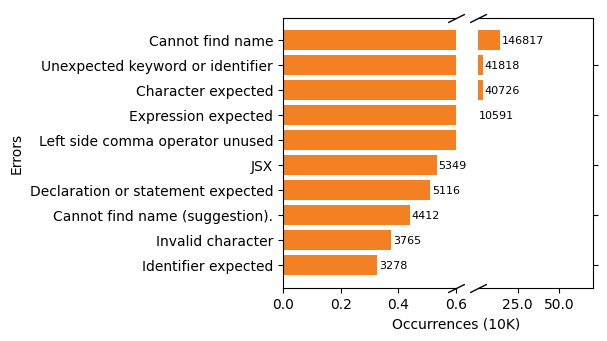

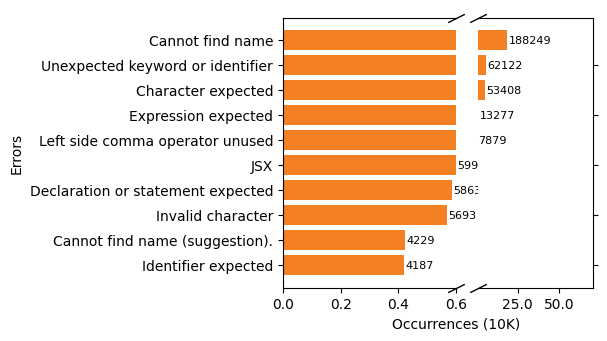

In [8]:
top10Errors(se_df, "NUM OCCURANCES", saveas="so_errorTypes", xlim=700000, 
    format = lambda x, p: format(int(x/100000), ','),
    title = "Most Common Errors",
    color = "SO")

top10Errors(sea_df, "NUM OCCURANCES", saveas="sof_errorTypes", xlim=700000, 
    format = lambda x, p: format(int(x/100000), ','),
    title = "Most Common Errors",
    color = "SO")

Across the entire set, error profile is similar to NPM results: Cannot find name remains the most common error.

## Improvement Set

This is the subset showing improvement we look at in the paper.

In [9]:
sei_df = soi_errors.errors
seia_df = soia_errors.errors
overview(soi_errors)
print("\nPost Edits---:")
overview(soia_errors)

print("")
p_increase(soi_errors.loc, soia_errors.loc, "LOC")
p_increase(soi_errors.totalErrors, soia_errors.totalErrors, "Errors")

print("")
print("Snippets that show improvement over time", soi_errors.snippets, "/", so_errors.snippets, "(", soi_errors.snippets/so_errors.snippets, ")")
print("Snippets that are corrected over time", sof_errors.snippets, "/", so_errors.snippets, "(", sof_errors.snippets/so_errors.snippets, ")")


Total Snippets: 15969
Total Errors: 160602
Average: 10.057110651888033
Total LOC: 197777
Snippets with no Errors: 0 / 15969 ( 0.0 )
Snippets with Errors: 15969/15969(1.0)
Average for Error Set: 10.057110651888033
Snippets Fixed 0/15969(0.0)
Snippets Empty 2/15969(0.00012524265764919532)

Post Edits---:
Total Snippets: 15969
Total Errors: 132343
Average: 8.287494520633729
Total LOC: 206180
Snippets with no Errors: 1099 / 15969 ( 0.06882084037823283 )
Snippets with Errors: 14870/15969(0.9311791596217671)
Average for Error Set: 8.9
Snippets Fixed 0/15969(0.0)
Snippets Empty 5/15969(0.0003131066441229883)

Percentage Increase of LOC : 4.25 % ( 8403 )
Percentage Increase of Errors : -17.6 % ( -28259 )

Snippets that show improvement over time 15969 / 21431 ( 0.7451355513041855 )
Snippets that are corrected over time 1099 / 21431 ( 0.05128085483645187 )


For this set, we see a 17.6% decrease in the number of errors, which we can argue is representative of a set with improvement. 1,099 snippets are made error free (6.88%).

### Most Common Types

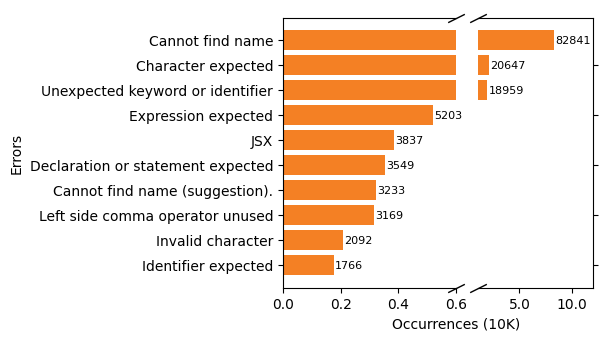

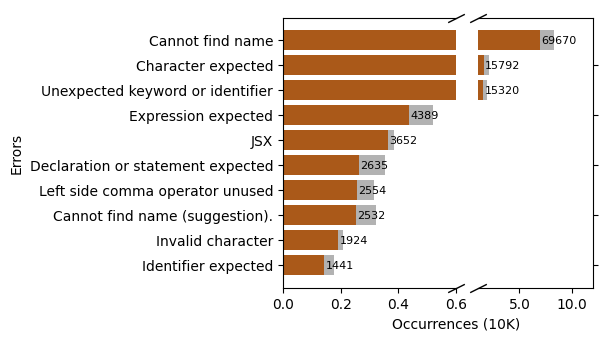

In [10]:
top10Errors(sei_df, "NUM OCCURANCES", saveas="soi_errorTypes", xlim=120000, 
    format = lambda x, p: format(int(x/100000), ','),
    title = "Most Common Errors",
    color = "SO")

top10Errors(seia_df, "NUM OCCURANCES", saveas="soif_errorTypes", xlim=120000, 
    format = lambda x, p: format(int(x/100000), ','),
    title = "Most Common Errors",
    color = "SO",
    df2 = sei_df)

## Edits That Fixed All Errors Only

I think it will be important to observe both the improvement and fixed sets for this comparison.

In [11]:
sef_df = sof_errors.errors
sefa_df = sofa_errors.errors
overview(sof_errors)
print()
# overview(sofa_errors)

Total Snippets: 1099
Total Errors: 3644
Average: 3.315741583257507
Total LOC: 13068
Snippets with no Errors: 0 / 1099 ( 0.0 )
Snippets with Errors: 1099/1099(1.0)
Average for Error Set: 3.315741583257507
Snippets Fixed 0/1099(0.0)
Snippets Empty 0/1099(0.0)



I am not sure the analysis compile doesn't match the compile used to sort snippets into subsets for 2 snippets, I'll look into this.
As it appears there are no errors, this may be a case of compile fail/timeout being counted as 'error-free'.

### Most Common Types

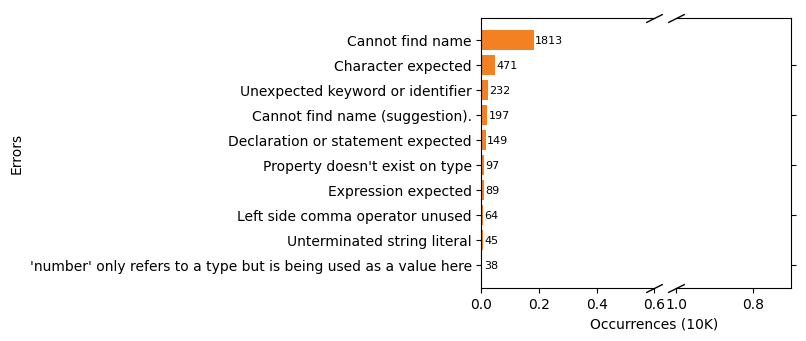

In [12]:
top10Errors(sef_df, "NUM OCCURANCES", saveas="sof_errorTypes", xlim=7000, 
    format = lambda x, p: format(int(x/100000), ','),
    title = "Most Common Errors",
    color = "SO")

# top10Errors(sefa_df, "NUM OCCURANCES", saveas="soff_errorTypes", xlim=700000, 
#     format = lambda x, p: format(int(x/100000), ','),
#     title = "Most Common Errors",
#     color = "ncc")

# After NCC

How do the error landscapes change after running NCC? How does this compare to the manual edits?

## All (Ignore)

In [13]:
overview(so_errors_af)
#compare to manual edits
print("\nManual edits:--")
overview(soa_errors)

Total Snippets: 21431
Total Errors: 20974
Average: 0.9786757500816574
Total LOC: 293593
Snippets with no Errors: 10445 / 21431 ( 0.4873780971489898 )
Snippets with Errors: 10986/21431(0.5126219028510102)
Average for Error Set: 1.9091571090478792
Snippets Fixed 19815/21431(0.9245952125425785)
Snippets Empty 1249/21431(0.05828006159301946)

Manual edits:--
Total Snippets: 21431
Total Errors: 383532
Average: 17.896131771732538
Total LOC: 306485
Snippets with no Errors: 1099 / 21431 ( 0.05128085483645187 )
Snippets with Errors: 20332/21431(0.9487191451635482)
Average for Error Set: 18.86346645681684
Snippets Fixed 0/21431(0.0)
Snippets Empty 5/21431(0.0002333068918855863)


In [14]:
print("Compared to original snippet")
p_increase(so_errors.totalErrors, so_errors_af.totalErrors, "Errors")
print("")
print("Compared to manual fix snippet")
p_increase(soa_errors.loc, so_errors_af.loc, "LOC")
p_increase(soa_errors.totalErrors, so_errors_af.totalErrors, "Errors")
p_increase(soa_errors.noErrors, so_errors_af.noErrors, "Snippets with no Errors")

Compared to original snippet
Percentage Increase of Errors : -92.88 % ( -273786 )

Compared to manual fix snippet
Percentage Increase of LOC : -4.21 % ( -12892 )
Percentage Increase of Errors : -94.53 % ( -362558 )
Percentage Increase of Snippets with no Errors : 850.41 % ( 9346 )


## Improvement Only Set

In [15]:
soi_af_df = soi_errors_af.errors

overview(soi_errors_af)
#compare to manual edits
print("\nManual Fixes:---")
overview(soia_errors)

Total Snippets: 15969
Total Errors: 14948
Average: 0.9360636232700857
Total LOC: 196234
Snippets with no Errors: 7469 / 15969 ( 0.4677187049909199 )
Snippets with Errors: 8500/15969(0.5322812950090801)
Average for Error Set: 1.7585882352941176
Snippets Fixed 15517/15969(0.9716951593712818)
Snippets Empty 912/15969(0.05711065188803306)

Manual Fixes:---
Total Snippets: 15969
Total Errors: 132343
Average: 8.287494520633729
Total LOC: 206180
Snippets with no Errors: 1099 / 15969 ( 0.06882084037823283 )
Snippets with Errors: 14870/15969(0.9311791596217671)
Average for Error Set: 8.9
Snippets Fixed 0/15969(0.0)
Snippets Empty 5/15969(0.0003131066441229883)


In [16]:
print("Compare to original snippets")
p_increase(soi_errors.loc, soi_errors_af.loc, "LOC")
p_increase(soi_errors.totalErrors, soi_errors_af.totalErrors, "Errors")
# p_increase(soi_errors.noErrors, soi_errors_af.noErrors, "Snippets with no Errors")

Compare to original snippets
Percentage Increase of LOC : -0.78 % ( -1543 )
Percentage Increase of Errors : -90.69 % ( -145654 )


In [17]:
print("Compare to manual fixes:")
p_increase(soia_errors.loc, soi_errors_af.loc, "LOC")
p_increase(soia_errors.totalErrors, soi_errors_af.totalErrors, "Errors")
p_increase(soia_errors.noErrors, soi_errors_af.noErrors, "Snippets with no Errors")

Compare to manual fixes:
Percentage Increase of LOC : -4.82 % ( -9946 )
Percentage Increase of Errors : -88.71 % ( -117395 )
Percentage Increase of Snippets with no Errors : 579.62 % ( 6370 )


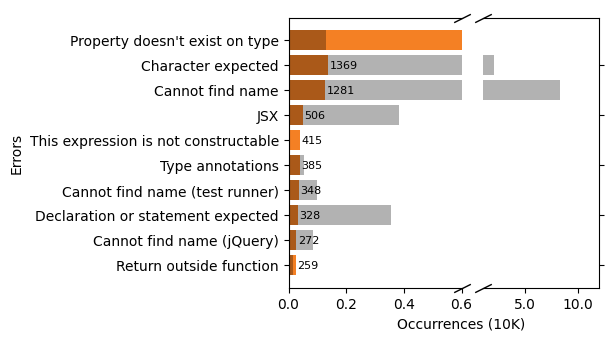

In [18]:
top10Errors(soi_af_df, "NUM OCCURANCES", saveas="soi_af_errorTypes", xlim=120000, 
    format = lambda x, p: format(int(x/100000), ','),
    title = "Most Common Errors",
    color = "SO",
    df2 = sei_df)

Decrease in LOC, large decrease in number of errors, and considerable error free snippet improvement.

## Fixed All Set

In [19]:
overview(sof_errors_af)
#compare to manual edits
print("\n")
overview(sofa_errors)
# print("\n")
# p_increase(sofa_errors.loc, sof_errors_af.loc, "LOC")
# # p_increase(sofa_errors.totalErrors, sof_errors_af.totalErrors, "Errors")
# p_increase(sofa_errors.noErrors, sof_errors_af.noErrors, "Snippets with no Errors")

Total Snippets: 1099
Total Errors: 566
Average: 0.5150136487716106
Total LOC: 13164
Snippets with no Errors: 726 / 1099 ( 0.6606005459508644 )
Snippets with Errors: 373/1099(0.33939945404913563)
Average for Error Set: 1.517426273458445
Snippets Fixed 1026/1099(0.9335759781619655)
Snippets Empty 47/1099(0.042766151046405826)


Total Snippets: 1099
Total Errors: 0
Average: 0.0
Total LOC: 15498
Snippets with no Errors: 1099 / 1099 ( 1.0 )
Snippets with Errors: 0/1099(0.0)
Average for Error Set: 0
Snippets Fixed 0/1099(0.0)
Snippets Empty 2/1099(0.0018198362147406734)


I need to account for some weirdness in the dataset (likely fail to compile or empty cases), but we can make 62\% of this dataset error free, with only a 13.5% empty rate.